# Deep Q-Network (DQN) for Gravity Guy

## What is DQN?
**Deep Q-Network (DQN)** is a reinforcement learning method that learns a function
$Q_\theta(s,a)$ estimating the long-term return of taking action $a$ in state $s$.
We act with **ε-greedy** (mostly pick the action with the highest Q, sometimes explore),
and we **train** the network to match a bootstrapped target:

$$
y = \begin{cases}
r & \text{if episode terminated}\\
r + \gamma \max_{a'} Q_{\bar\theta}(s', a') & \text{otherwise}
\end{cases}
$$

$$
\text{Loss} = \mathrm{Huber}\big( Q_\theta(s,a) - y \big)
$$

Two stabilizers make DQN work well in practice:
- **Replay buffer**: learn from randomized past transitions $(s,a,r,s',\text{done})$ to break correlations.
- **Target network** $Q_{\bar\theta}$: a slowly updated copy used to compute $y$.

## Why DQN fits this game
- **Tiny, discrete action space:** 2 actions (NOOP / FLIP).
- **Dense, shaped reward:** per-step progress minus a small flip penalty.
- **Compact observation:** 6 floats capture what matters (vertical state + look-ahead probes).
- **Fast, headless env:** high sample throughput for replay.

## State / Action / Reward (this notebook)
- **Observation (6 floats):**
  1. `y_norm` ∈ [0,1] — vertical position (0=top, 1=bottom)  
  2. `vy_norm` ∈ [-1,1] — normalized vertical speed  
  3. `grav_dir` ∈ {−1,+1} — current gravity (up/down)  
  4–6. `p1, p2, p3` ∈ [0,1] — **look-ahead clearances** in the gravity direction (near → far)
- **Actions:** `0 = NOOP`, `1 = FLIP` (flip only **fires** when grounded & cooldown is over; invalid flips act as no-ops).
- **Reward per step:** `progress − flip_penalty × [flip_fired]`
- **Termination:** off-screen (death) or time limit (e.g., 10 s).

## Learning loop (at a glance)
1. **Observe** state $s$.  
2. **Act** with ε-greedy: pick `argmax_a Q_\theta(s,a)` with prob $1-ε$, random action with prob $ε$.  
3. **Step** the env → get $(r, s', \text{done})$.  
4. **Store** $(s,a,r,s',\text{done})$ in the replay buffer.  
5. **Sample** a mini-batch from replay, compute targets $y$ with the **target network**.  
6. **Update** the online network $Q_\theta$ to minimize Huber loss; periodically **update** the target network.  
7. **Anneal** $ε$ over time to reduce exploration.

## Game-specific caveats (and how we handle them)
- **Action validity:** flips only take effect when grounded.  
  *Mitigation:* treat invalid flips as no-ops and/or mask them at action selection time.
- **Timing & partial observability:** probes look ahead in x while y changes over time.  
  *Mitigation:* keep the observation compact but informative (probes + gravity + velocity).  
  (Optionally, stack a few recent observations or add `grounded`/`cooldown` scalars.)
- **Evaluation fairness:** fix a set of level seeds; report mean/median distance, % time-limit terminations, and flips per 1000 px.

## What the reader should expect
- Baselines (**Random**, **Heuristic**) for context.  
- A DQN agent that learns to time flips better than random, often matching or surpassing the hand-crafted heuristic on held-out seeds.  
- Clear plots: training return, evaluation distance, and failure-mode breakdown.


## Environment Setup

Let's start by setting up our environment and importing the libraries we'll need:

In [2]:
# Standard libraries for ML and data handling
import numpy as np
import matplotlib.pyplot as plt
import random
import json
from collections import deque
import time

# PyTorch for neural networks (you might need: pip install torch)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Our custom environment
import sys
sys.path.append('../..')  # Go up two directories to access src/
from src.env.gg_env import GGEnv

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

pygame 2.5.2 (SDL 2.28.3, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html
Libraries imported successfully!
PyTorch version: 2.8.0+cpu
Using device: CPU


## Quick Environment Test

Before building our AI, let's make sure we understand our environment perfectly:

In [3]:
# Create a test environment
env = GGEnv(level_seed=12345, max_time_s=10.0, flip_penalty=0.01)
obs = env.reset()

print("=== ENVIRONMENT UNDERSTANDING ===")
print(f"Observation space: {len(obs)} dimensions")
print(f"Action space: {env.action_space_n} actions (0=wait, 1=flip)")
print(f"First observation: {obs}")

# Take a few random actions to see what happens
total_reward = 0
for step in range(10):
    action = random.choice([0, 1])  # Random action
    obs, reward, done, info = env.step(action)
    total_reward += reward
    
    print(f"Step {step+1}: action={action}, reward={reward:.3f}, done={done}")
    print(f"  → obs: [{obs[0]:.2f}, {obs[1]:.2f}, {obs[2]:.0f}, {obs[3]:.2f}, {obs[4]:.2f}, {obs[5]:.2f}]")
    
    if done:
        print(f"Episode ended! Total reward: {total_reward:.2f}, Distance: {info['distance_px']}px")
        break

print("\n✅ Environment test completed!")

=== ENVIRONMENT UNDERSTANDING ===
Observation space: 6 dimensions
Action space: 2 actions (0=wait, 1=flip)
First observation: [0.5, 0.0, 1.0, 0.24814814814814815, 0.24814814814814815, 0.24814814814814815]
Step 1: action=1, reward=2.083, done=False
  → obs: [0.50, 0.01, 1, 0.25, 0.25, 0.25]
Step 2: action=0, reward=2.083, done=False
  → obs: [0.50, 0.03, 1, 0.25, 0.25, 0.25]
Step 3: action=0, reward=2.083, done=False
  → obs: [0.50, 0.04, 1, 0.25, 0.25, 0.25]
Step 4: action=0, reward=2.083, done=False
  → obs: [0.50, 0.05, 1, 0.25, 0.25, 0.25]
Step 5: action=0, reward=2.083, done=False
  → obs: [0.50, 0.06, 1, 0.25, 0.25, 0.25]
Step 6: action=1, reward=2.083, done=False
  → obs: [0.51, 0.07, 1, 0.24, 0.24, 0.24]
Step 7: action=1, reward=2.083, done=False
  → obs: [0.51, 0.09, 1, 0.24, 0.24, 0.24]
Step 8: action=0, reward=2.083, done=False
  → obs: [0.51, 0.10, 1, 0.24, 0.24, 0.24]
Step 9: action=0, reward=2.083, done=False
  → obs: [0.51, 0.11, 1, 0.24, 0.24, 0.24]
Step 10: action=1, re

## Part 2: Building the Neural Network Brain

### What is our Neural Network doing?

Think of the neural network as the agent's "brain". It takes in the 6 observations from the game and outputs 2 numbers:
- **Q(state, wait)**: How good is it to wait/do nothing in this situation?
- **Q(state, flip)**: How good is it to flip gravity in this situation?

The agent will always choose the action with the higher Q-value.

### Network Architecture Design

For our Gravity Guy game, we'll use a simple but effective architecture:

```
Input Layer (6 neurons) → Hidden Layer (128 neurons) → Hidden Layer (64 neurons) → Output Layer (2 neurons)
       ↓                        ↓                           ↓                        ↓
  [y, vy, grav,              [lots of                   [more                   [Q(wait), 
   p1, p2, p3]                neurons]                   neurons]                 Q(flip)]
```

### Why this architecture?
- **Input**: 6 observations (exactly what our environment gives us)
- **Hidden layers**: 128 and 64 neurons - enough to learn complex patterns but not too big to be slow
- **Output**: 2 Q-values (one for each possible action)
- **Activation**: ReLU (simple and effective for this type of problem)
- **Why this size?** Small enough to be fast, large enough to capture the timing patterns in probes/velocity.
- **Activation:** ReLU in hidden layers, **linear** in the output (Q-values can be any real number).
- **Parameter budget (intuition):** ~6×128 + 128×64 + 64×2 weights (+ biases) → ~12k parameters—tiny and trainable.


### How it fits into the DQN loop
1. **Forward pass:** $Q_\theta(s)$ → two Q-values.  
2. **Act:** choose action via ε-greedy (with optional mask).  
3. **Store:** add $(s,a,r,s',\text{done})$ to replay.  
4. **Target:** $y = r + \gamma \max_{a'} Q_{\bar\theta}(s',a')$ (or $y=r$ on terminal).  
5. **Update:** minimize Huber$(Q_\theta(s,a) - y)$.  
6. **Stabilize:** periodically copy online weights to the **target network** (or use soft updates).


## Neural Network Implementation

In [4]:
class DQN(nn.Module):
    """
    Deep Q-Network for Gravity Guy
    
    This neural network takes game observations and predicts Q-values for each action.
    Think of it as the "brain" that learns to evaluate how good each action is.
    """
    
    def __init__(self, input_size=6, hidden_size1=128, hidden_size2=64, output_size=2):
        """
        Initialize the network layers
        
        Args:
            input_size: Number of observations (6 for our game)
            hidden_size1: First hidden layer size (128 neurons)
            hidden_size2: Second hidden layer size (64 neurons)  
            output_size: Number of actions (2: wait or flip)
        """
        super(DQN, self).__init__()
        
        # Define the network layers
        self.fc1 = nn.Linear(input_size, hidden_size1)      # Input → Hidden1
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)    # Hidden1 → Hidden2  
        self.fc3 = nn.Linear(hidden_size2, output_size)     # Hidden2 → Output
        
        print(f"🧠 DQN Network Created:")
        print(f"   Input: {input_size} → Hidden: {hidden_size1} → Hidden: {hidden_size2} → Output: {output_size}")
        print(f"   Total parameters: {sum(p.numel() for p in self.parameters()):,}")
    
    def forward(self, x):
        """
        Forward pass: convert observations into Q-values
        
        This is where the magic happens - observations go in, Q-values come out!
        
        Args:
            x: Observations tensor [batch_size, 6]
            
        Returns:
            Q-values tensor [batch_size, 2] - one Q-value for each action
        """
        # Layer 1: observations → first hidden layer (with ReLU activation)
        x = F.relu(self.fc1(x))
        
        # Layer 2: first hidden → second hidden layer (with ReLU activation)  
        x = F.relu(self.fc2(x))
        
        # Layer 3: second hidden → Q-values (no activation - we want raw Q-values)
        q_values = self.fc3(x)
        
        return q_values

# Test our network
print("=== TESTING THE NEURAL NETWORK ===")

# Create the network
dqn = DQN(input_size=6, output_size=2)

# Test with a fake observation (like what our environment produces)
test_observation = torch.tensor([0.5, 0.2, 1.0, 0.8, 0.9, 1.0], dtype=torch.float32)
test_observation = test_observation.unsqueeze(0)  # Add batch dimension

# Get Q-values from the network
with torch.no_grad():  # No gradients needed for testing
    q_values = dqn(test_observation)

print(f"Test observation: {test_observation.squeeze().tolist()}")
print(f"Network output (Q-values): {q_values.squeeze().tolist()}")
print(f"Best action: {torch.argmax(q_values).item()} ({'flip' if torch.argmax(q_values).item() == 1 else 'wait'})")

print("\n✅ Neural Network test completed!")

=== TESTING THE NEURAL NETWORK ===
🧠 DQN Network Created:
   Input: 6 → Hidden: 128 → Hidden: 64 → Output: 2
   Total parameters: 9,282
Test observation: [0.5, 0.20000000298023224, 1.0, 0.800000011920929, 0.8999999761581421, 1.0]
Network output (Q-values): [-0.017518017441034317, 0.1913231462240219]
Best action: 1 (flip)

✅ Neural Network test completed!


## Understanding the Network Components

In [5]:
print("=== UNDERSTANDING NETWORK COMPONENTS ===")

# Let's examine what each layer does
test_obs = torch.tensor([0.3, -0.1, -1.0, 0.6, 0.7, 0.8], dtype=torch.float32).unsqueeze(0)

print("Step-by-step forward pass:")
print(f"1. Input observations: {test_obs.squeeze().tolist()}")

# Manual forward pass to see each step
x = test_obs
print(f"   Shape: {x.shape}")

# Layer 1
x = F.relu(dqn.fc1(x))  
print(f"2. After first hidden layer (128 neurons): {x.shape}")
print(f"   Sample values: [{x[0][0]:.3f}, {x[0][1]:.3f}, {x[0][2]:.3f}, ...] (showing first 3)")

# Layer 2  
x = F.relu(dqn.fc2(x))
print(f"3. After second hidden layer (64 neurons): {x.shape}")
print(f"   Sample values: [{x[0][0]:.3f}, {x[0][1]:.3f}, {x[0][2]:.3f}, ...] (showing first 3)")

# Layer 3
x = dqn.fc3(x)
print(f"4. Final Q-values: {x.squeeze().tolist()}")
print(f"   Q(wait) = {x[0][0]:.3f}, Q(flip) = {x[0][1]:.3f}")

# Decision making
best_action = torch.argmax(x).item()
print(f"5. Decision: Choose action {best_action} ({'flip' if best_action == 1 else 'wait'})")

=== UNDERSTANDING NETWORK COMPONENTS ===
Step-by-step forward pass:
1. Input observations: [0.30000001192092896, -0.10000000149011612, -1.0, 0.6000000238418579, 0.699999988079071, 0.800000011920929]
   Shape: torch.Size([1, 6])
2. After first hidden layer (128 neurons): torch.Size([1, 128])
   Sample values: [0.138, 0.000, 0.251, ...] (showing first 3)
3. After second hidden layer (64 neurons): torch.Size([1, 64])
   Sample values: [0.000, 0.286, 0.295, ...] (showing first 3)
4. Final Q-values: [-0.03923904523253441, 0.226438507437706]
   Q(wait) = -0.039, Q(flip) = 0.226
5. Decision: Choose action 1 (flip)


## Key Concepts Explained

**What just happened?**

1. **Input Processing**: We fed the network 6 numbers representing the game state
2. **Hidden Layers**: The network processed this information through two layers of neurons
3. **Q-Value Output**: We got back 2 numbers - Q(wait) and Q(flip)  
4. **Action Selection**: We pick the action with the highest Q-value

**Why ReLU activation?**
- ReLU (Rectified Linear Unit) simply makes negative values = 0
- It's fast, simple, and works well for most problems
- Helps the network learn complex patterns

**Why no activation on the output?**
- Q-values can be positive or negative (good or bad situations)  
- We want the raw values, not constrained to 0-1 range

## Part 3: Building the Agent's Memory System (Experience Replay Buffer)

### What is Experience Replay?

**The Problem with Naive Learning:**
Imagine trying to learn to drive by only remembering your last 1 second of driving. You'd never learn patterns like "red light ahead → slow down" because you'd forget the red light by the time you needed to brake.

**The Solution - Experience Replay:**
Instead of learning from just the current experience, we store the agent's experiences in a "memory buffer" and learn from random samples. This breaks the correlation between consecutive experiences and stabilizes learning.

**Key Benefits:**
1. **Breaks Correlation**: Learning from random past experiences prevents overfitting to current situation
2. **Sample Efficiency**: Reuse valuable experiences multiple times  
3. **Stability**: Smooths out learning by averaging over diverse situations

### Experience Replay Buffer Implementation

In [6]:
import random
from collections import deque
import numpy as np

class ReplayBuffer:
    """
    Experience Replay Buffer for DQN Agent
    
    This is the agent's "memory" - it stores past experiences and lets us
    sample random batches for training. Think of it as a photo album of
    game moments that we can learn from later.
    
    Each experience is a tuple: (state, action, reward, next_state, done)
    """
    
    def __init__(self, capacity=100000):
        """
        Initialize the replay buffer
        
        Args:
            capacity: Maximum number of experiences to store
                     (older experiences get overwritten when full)
        """
        self.buffer = deque(maxlen=capacity)
        self.capacity = capacity
        
        print(f"🧠 Replay Buffer Created:")
        print(f"   Capacity: {capacity:,} experiences")
        print(f"   Memory usage: ~{capacity * 6 * 4 / 1024 / 1024:.1f} MB")  # Rough estimate
    
    def push(self, state, action, reward, next_state, done):
        """
        Store a new experience in the buffer
        
        Args:
            state: Current observation (6D vector)
            action: Action taken (0 or 1)  
            reward: Reward received
            next_state: Next observation after action
            done: True if episode ended
        """
        # Convert to numpy arrays for consistency
        state = np.array(state, dtype=np.float32)
        next_state = np.array(next_state, dtype=np.float32)
        
        # Store as tuple
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)
    
    def sample(self, batch_size=32):
        """
        Sample a random batch of experiences for training
        
        This is where the magic happens - we grab random past experiences
        to train on, which breaks the correlation problem.
        
        Args:
            batch_size: Number of experiences to sample
            
        Returns:
            Tuple of tensors: (states, actions, rewards, next_states, dones)
        """
        if len(self.buffer) < batch_size:
            raise ValueError(f"Not enough experiences! Have {len(self.buffer)}, need {batch_size}")
        
        # Sample random batch
        batch = random.sample(self.buffer, batch_size)
        
        # Unpack batch into separate arrays
        states = np.array([e[0] for e in batch])
        actions = np.array([e[1] for e in batch]) 
        rewards = np.array([e[2] for e in batch])
        next_states = np.array([e[3] for e in batch])
        dones = np.array([e[4] for e in batch])
        
        # Convert to PyTorch tensors
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)  # Long for indexing
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.bool)
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        """Return current number of experiences stored"""
        return len(self.buffer)
    
    def is_ready(self, min_size=1000):
        """Check if buffer has enough experiences to start training"""
        return len(self.buffer) >= min_size

# Test the replay buffer
print("=== TESTING REPLAY BUFFER ===")

# Create buffer
replay_buffer = ReplayBuffer(capacity=50000)

# Add some fake experiences
for i in range(100):
    state = [0.5, 0.1, 1.0, 0.8, 0.9, 1.0]  # Fake observation
    action = random.choice([0, 1])           # Random action
    reward = 2.0 + random.random()           # Small reward variation
    next_state = [0.51, 0.12, 1.0, 0.75, 0.85, 0.95]  # Slightly different
    done = (i % 50 == 49)                    # Episode ends every 50 steps
    
    replay_buffer.push(state, action, reward, next_state, done)

print(f"Buffer size after adding 100 experiences: {len(replay_buffer)}")

# Test sampling
if replay_buffer.is_ready(min_size=32):
    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size=8)
    
    print(f"\n=== SAMPLE BATCH (size=8) ===")
    print(f"States shape: {states.shape}")
    print(f"Actions shape: {actions.shape}")
    print(f"Rewards shape: {rewards.shape}")
    
    print(f"\nSample states (first 3):")
    for i in range(3):
        print(f"  State {i}: {states[i].tolist()}")
    
    print(f"\nSample actions: {actions.tolist()}")
    print(f"Sample rewards: {rewards.tolist()}")
    print(f"Sample dones: {dones.tolist()}")
    
    print(f"\n✅ Replay buffer working correctly!")
else:
    print("❌ Not enough experiences to sample")

=== TESTING REPLAY BUFFER ===
🧠 Replay Buffer Created:
   Capacity: 50,000 experiences
   Memory usage: ~1.1 MB
Buffer size after adding 100 experiences: 100

=== SAMPLE BATCH (size=8) ===
States shape: torch.Size([8, 6])
Actions shape: torch.Size([8])
Rewards shape: torch.Size([8])

Sample states (first 3):
  State 0: [0.5, 0.10000000149011612, 1.0, 0.800000011920929, 0.8999999761581421, 1.0]
  State 1: [0.5, 0.10000000149011612, 1.0, 0.800000011920929, 0.8999999761581421, 1.0]
  State 2: [0.5, 0.10000000149011612, 1.0, 0.800000011920929, 0.8999999761581421, 1.0]

Sample actions: [0, 1, 0, 0, 1, 0, 1, 0]
Sample rewards: [2.5256736278533936, 2.343681812286377, 2.807798385620117, 2.334061622619629, 2.9223079681396484, 2.3156423568725586, 2.228273868560791, 2.3375918865203857]
Sample dones: [False, False, False, False, False, False, False, False]

✅ Replay buffer working correctly!


### Understanding the Memory System

**Key Concepts Explained:**

1. **Capacity Management**: 
   - Buffer has fixed size (100,000 experiences)
   - When full, oldest experiences are overwritten
   - This prevents memory from growing infinitely

2. **Experience Format**:
   ```python
   (state, action, reward, next_state, done)
   # Example: ([0.5, 0.1, 1.0, 0.8, 0.9, 1.0], 1, 2.1, [0.51, 0.12, 1.0, 0.75, 0.85, 0.95], False)
   ```

3. **Random Sampling**:
   - We don't learn from experiences in order
   - Random sampling breaks temporal correlations
   - Each training batch has diverse situations

4. **Batch Processing**:
   - Sample multiple experiences at once (e.g., 32)
   - More efficient than training on single experiences
   - Provides better gradient estimates

### Why This Matters for Gravity Guy

**Without Replay Buffer:**
- Agent only learns from current situation
- Forgets valuable lessons from past mistakes
- Training is unstable and inefficient

**With Replay Buffer:**
- Learns from diverse situations (different platform layouts, gravity states)
- Remembers rare but important events (close calls, successful flips)
- Training is stable and data-efficient

**Memory Efficiency:**
- 100,000 experiences ≈ 25MB of memory (very reasonable)
- Enough to store ~30 minutes of gameplay at 60 FPS
- Captures diverse situations for robust learning

### Next Steps

Now that we have our replay buffer, we need:
1. **DQN Agent Class** - Combines neural network + replay buffer
2. **Training Loop** - The learning process
3. **Epsilon-Greedy Policy** - Balancing exploration vs exploitation

The replay buffer is the foundation that makes everything else possible!

## Part 4: The Complete DQN Agent

### What We're Building

Now we combine everything into a complete learning agent:
- **Brain**: Neural network (from Part 2) 
- **Memory**: Replay buffer (from Part 3)
- **Decision Making**: Epsilon-greedy exploration
- **Learning**: DQN training algorithm

Think of this as assembling all the pieces into a complete AI player.

### Key Concepts

**🧠 Epsilon-Greedy Strategy:**
- **Exploration**: Sometimes take random actions to discover new strategies
- **Exploitation**: Usually take the action our network thinks is best
- **Balance**: Start with high exploration (90%), gradually reduce to low (5%)

**🎯 DQN Learning Process:**
1. Observe current state
2. Choose action (epsilon-greedy)
3. Take action, get reward and new state
4. Store experience in replay buffer
5. Sample random batch from memory
6. Train network on batch
7. Repeat!

### Complete DQN Agent Implementation

In [7]:
import torch.nn.functional as F
import math

class DQNAgent:
    """
    Complete Deep Q-Network Agent for Gravity Guy
    
    This agent combines:
    - Neural network for decision making
    - Replay buffer for experience storage  
    - Epsilon-greedy exploration strategy
    - DQN training algorithm
    """
    
    def __init__(
        self,
        state_size=6,
        action_size=2, 
        learning_rate=0.0003,
        gamma=0.99,
        epsilon_start=0.95,
        epsilon_end=0.05,
        epsilon_decay=0.995,
        buffer_size=50000,
        batch_size=32,
        target_update_freq=1000
    ):
        """
        Initialize the DQN agent
        
        Args:
            state_size: Size of observation space (6 for Gravity Guy)
            action_size: Number of actions (2: wait/flip)
            learning_rate: How fast the network learns
            gamma: Discount factor (how much future rewards matter)
            epsilon_start: Initial exploration rate (95% random actions)
            epsilon_end: Final exploration rate (5% random actions)  
            epsilon_decay: How quickly we reduce exploration
            buffer_size: Replay buffer capacity
            batch_size: Number of experiences per training batch
            target_update_freq: How often to update target network
        """
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        
        # Exploration parameters
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
        # Neural networks (main and target)
        self.q_network = DQN(state_size, 128, 64, action_size)
        self.target_network = DQN(state_size, 128, 64, action_size)
        
        # Initialize target network with same weights as main network
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        # Optimizer for training
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        
        # Experience replay buffer
        self.memory = ReplayBuffer(buffer_size)
        
        # Training step counter
        self.steps_done = 0
        
        print(f"🤖 DQN Agent Initialized:")
        print(f"   State/Action space: {state_size} → {action_size}")
        print(f"   Learning rate: {learning_rate}")
        print(f"   Exploration: {epsilon_start:.2f} → {epsilon_end:.2f}")
        print(f"   Buffer size: {buffer_size:,}")
        print(f"   Batch size: {batch_size}")
    
    def act(self, state, training=True):
        """
        Choose action using epsilon-greedy strategy
        
        Args:
            state: Current observation (6D vector)
            training: If False, always exploit (no exploration)
            
        Returns:
            action: 0 (wait) or 1 (flip)
        """
        # Convert state to tensor
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32)
        if state.dim() == 1:
            state = state.unsqueeze(0)  # Add batch dimension
        
        # Epsilon-greedy action selection
        if training and random.random() < self.epsilon:
            # Explore: random action
            action = random.choice([0, 1])
        else:
            # Exploit: best action according to Q-network
            with torch.no_grad():
                q_values = self.q_network(state)
                action = torch.argmax(q_values[0]).item()
        
        return action
    
    def step(self, state, action, reward, next_state, done):
        """
        Store experience and learn from replay buffer
        
        Args:
            state: Previous observation
            action: Action taken
            reward: Reward received  
            next_state: New observation
            done: True if episode ended
        """
        # Store experience in replay buffer
        self.memory.push(state, action, reward, next_state, done)
        
        # Increment step counter
        self.steps_done += 1
        
        # Learn from experiences (if we have enough)
        if self.memory.is_ready(self.batch_size):
            experiences = self.memory.sample(self.batch_size)
            self._learn(experiences)
        
        # Update target network periodically
        if self.steps_done % self.target_update_freq == 0:
            self._update_target_network()
        
        # Decay exploration rate
        if self.epsilon > self.epsilon_end:
            self.epsilon *= self.epsilon_decay
    
    def _learn(self, experiences):
        """
        Learn from a batch of experiences using DQN algorithm
        
        This is where the actual learning happens!
        """
        states, actions, rewards, next_states, dones = experiences
        
        # Get current Q-values for chosen actions
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        
        # Get next Q-values from target network
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            # Set next Q-values to 0 for terminal states
            next_q_values[dones] = 0.0
        
        # Compute target Q-values
        target_q_values = rewards + (self.gamma * next_q_values)
        
        # Compute loss (Huber loss for stability)
        loss = F.smooth_l1_loss(current_q_values.squeeze(), target_q_values)
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=1.0)
        self.optimizer.step()
        
        return loss.item()
    
    def _update_target_network(self):
        """Copy weights from main network to target network"""
        self.target_network.load_state_dict(self.q_network.state_dict())
        print(f"🎯 Target network updated at step {self.steps_done}")
    
    def save(self, filepath):
        """Save the trained model"""
        torch.save({
            'q_network_state_dict': self.q_network.state_dict(),
            'target_network_state_dict': self.target_network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'steps_done': self.steps_done
        }, filepath)
        print(f"💾 Model saved to {filepath}")
    
    def load(self, filepath):
        """Load a trained model"""
        checkpoint = torch.load(filepath)
        self.q_network.load_state_dict(checkpoint['q_network_state_dict'])
        self.target_network.load_state_dict(checkpoint['target_network_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']
        self.steps_done = checkpoint['steps_done']
        print(f"📂 Model loaded from {filepath}")

# Test the complete agent
print("=== TESTING COMPLETE DQN AGENT ===")

# Create agent
agent = DQNAgent(
    state_size=6,
    action_size=2,
    learning_rate=0.001,
    epsilon_start=0.9,
    epsilon_end=0.05,
    buffer_size=10000,  # Smaller for testing
    batch_size=32
)

print(f"\n=== TESTING ACTION SELECTION ===")

# Test action selection
test_states = [
    [0.3, -0.1, 1.0, 0.8, 0.9, 1.0],  # Safe situation
    [0.7, 0.2, -1.0, 0.2, 0.3, 0.4],  # Dangerous situation  
    [0.5, 0.0, 1.0, 1.0, 1.0, 1.0],   # Very safe
]

for i, state in enumerate(test_states):
    action_explore = agent.act(state, training=True)   # With exploration
    action_exploit = agent.act(state, training=False)  # Pure exploitation
    
    print(f"State {i+1}: explore={action_explore}, exploit={action_exploit}")

print(f"\n=== TESTING LEARNING PROCESS ===")

# Add some experiences and test learning
for i in range(100):
    state = [0.5 + 0.1*random.random(), 0.1*random.random(), 
             random.choice([-1, 1]), 0.8*random.random(), 
             0.8*random.random(), 0.8*random.random()]
    action = random.choice([0, 1])
    reward = 2.0 + random.random()
    next_state = [s + 0.01*random.random() for s in state]
    done = (i % 25 == 24)
    
    agent.step(state, action, reward, next_state, done)

print(f"Agent trained on 100 experiences")
print(f"Current exploration rate: {agent.epsilon:.3f}")
print(f"Memory size: {len(agent.memory)}")
print(f"Training steps completed: {agent.steps_done}")

print(f"\n✅ DQN Agent is ready for training!")

=== TESTING COMPLETE DQN AGENT ===
🧠 DQN Network Created:
   Input: 6 → Hidden: 128 → Hidden: 64 → Output: 2
   Total parameters: 9,282
🧠 DQN Network Created:
   Input: 6 → Hidden: 128 → Hidden: 64 → Output: 2
   Total parameters: 9,282
🧠 Replay Buffer Created:
   Capacity: 10,000 experiences
   Memory usage: ~0.2 MB
🤖 DQN Agent Initialized:
   State/Action space: 6 → 2
   Learning rate: 0.001
   Exploration: 0.90 → 0.05
   Buffer size: 10,000
   Batch size: 32

=== TESTING ACTION SELECTION ===
State 1: explore=0, exploit=1
State 2: explore=0, exploit=0
State 3: explore=0, exploit=1

=== TESTING LEARNING PROCESS ===
Agent trained on 100 experiences
Current exploration rate: 0.545
Memory size: 100
Training steps completed: 100

✅ DQN Agent is ready for training!


**🧠 The Learning Process:**

1. **Observe**: Get current game state (6D vector)
2. **Decide**: Use epsilon-greedy to pick action
3. **Act**: Take action in environment  
4. **Remember**: Store experience in replay buffer
5. **Learn**: Train on random batch from memory
6. **Improve**: Update exploration rate and target network

**🎯 Key Components:**

- **Main Network**: Makes decisions and gets trained
- **Target Network**: Provides stable learning targets (updated every 1000 steps)
- **Epsilon Decay**: Exploration decreases over time (95% → 5%)
- **Experience Replay**: Learns from diverse past experiences

**🚀 Why This Works for Gravity Guy:**

- **Exploration**: Discovers new flipping strategies
- **Memory**: Remembers successful and failed situations  
- **Stability**: Target network prevents learning instability
- **Efficiency**: Batch training is much faster than single updates

### Next Steps

Your agent is now complete! Next we need:
1. **Training Loop** - Connect agent to your environment
2. **Performance Monitoring** - Track learning progress
3. **Evaluation** - Test against baseline agents

Ready to see this agent learn to play Gravity Guy? 🎮

## Part 5: Training the DQN Agent

### The Magic Moment! 🎮

This is where everything comes together. We'll:
1. Connect our agent to your Gravity Guy environment
2. Watch it learn from random play to intelligent behavior
3. Track its progress against your baseline agents
4. See it (hopefully) beat the 2001px heuristic baseline!

**Goal.** Run episodic training for a DQN agent on Gravity-Guide.

**What happens each episode**
1. Create a fresh headless environment and reset to the first observation.  
2. Act with **ε-greedy** (mostly argmax Q, sometimes explore).  
3. Store transitions in the **replay buffer** and train on random mini-batches.  
4. Track metrics: total reward, distance (px), steps, and mean loss (if any).  
5. Save checkpoints periodically.

**Notes**
- Start with high exploration (ε≈1.0) and decay over time.
- Keep a **fixed time limit** per episode (e.g., 30s) to normalize returns.
- Print rolling averages to monitor learning stability.

**Function signature**

- **Args**
  - `agent` (*object*): must expose `act(state, training: bool)`, `remember(...)`, `replay()` and optionally `save(path)`, `.epsilon`, and `.memory`.
  - `episodes` (*int*): number of training episodes.
  - `max_steps_per_episode` (*int*): hard cap on steps per episode.
  - `save_every` (*int*): save a checkpoint every N episodes.

- **Returns**
  - `(agent, episode_rewards, episode_distances, losses)`  
    - `episode_rewards` — list of per-episode total reward  
    - `episode_distances` — list of final `distance_px` per episode  
    - `losses` — list of mean training loss per episode (if produced)

### Training Setup


=== CREATING DQN AGENT FOR TRAINING ===
🧠 DQN Network Created:
   Input: 6 → Hidden: 128 → Hidden: 64 → Output: 2
   Total parameters: 9,282
🧠 DQN Network Created:
   Input: 6 → Hidden: 128 → Hidden: 64 → Output: 2
   Total parameters: 9,282
🧠 Replay Buffer Created:
   Capacity: 50,000 experiences
   Memory usage: ~1.1 MB
🤖 DQN Agent Initialized:
   State/Action space: 6 → 2
   Learning rate: 0.0001
   Exploration: 0.95 → 0.05
   Buffer size: 50,000
   Batch size: 64

🎮 Ready to train! Starting with quick test...
=== QUICK TEST (10 episodes) ===
🚀 Starting DQN Training!
Episodes: 10
Target: Beat heuristic baseline of 2001px
Environment: 30s episodes, random levels
------------------------------------------------------------
🎯 Target network updated at step 1000
Episode    2 | Distance: 1615px | Avg: 1589px | Best: 1615px | ε: 0.050
🎯 Target network updated at step 2000
🎯 Target network updated at step 3000
Episode    4 | Distance: 1677px | Avg: 1685px | Best: 1887px | ε: 0.050
🎯 Target

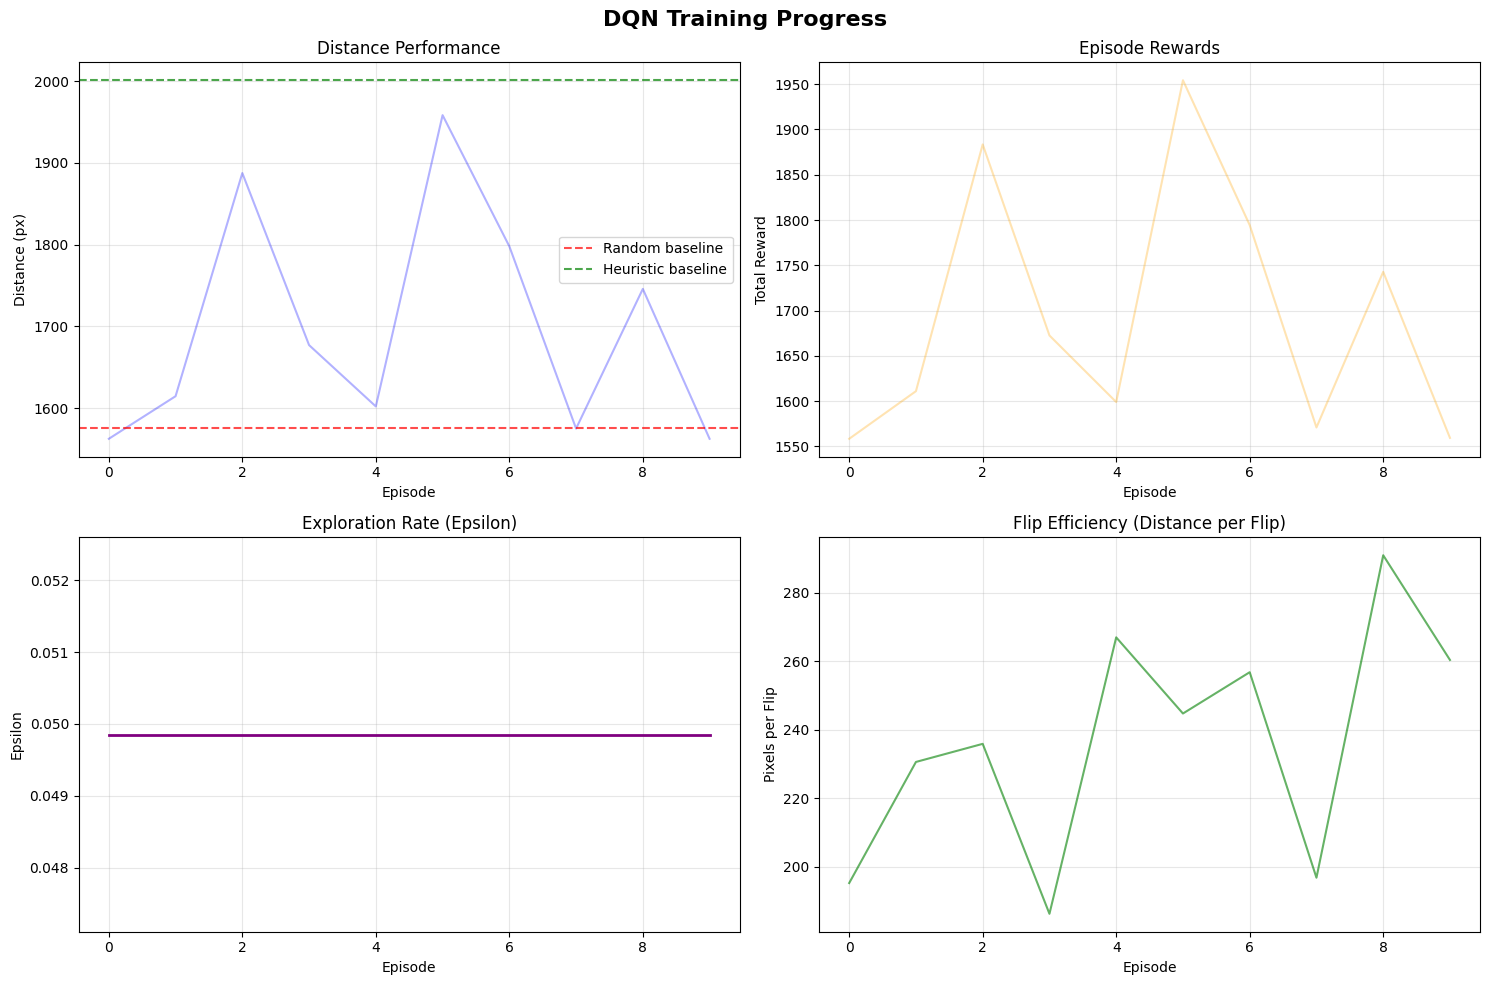

Current 100-episode average: 1698px
Best distance so far: 1958px (episode 6)
✅ Beating random baseline by 7.8%!
------------------------------------------------------------

🏁 Training Complete!
Total time: 0.2 minutes
Final 100-episode average: 1698px
Best distance achieved: 1958px

📊 Final Performance Comparison:
Random baseline:    1,576px
Heuristic baseline: 2,001px
DQN agent:          1698px
✅ Good progress! Beat random by 7.8%

📈 Final Training Visualization:


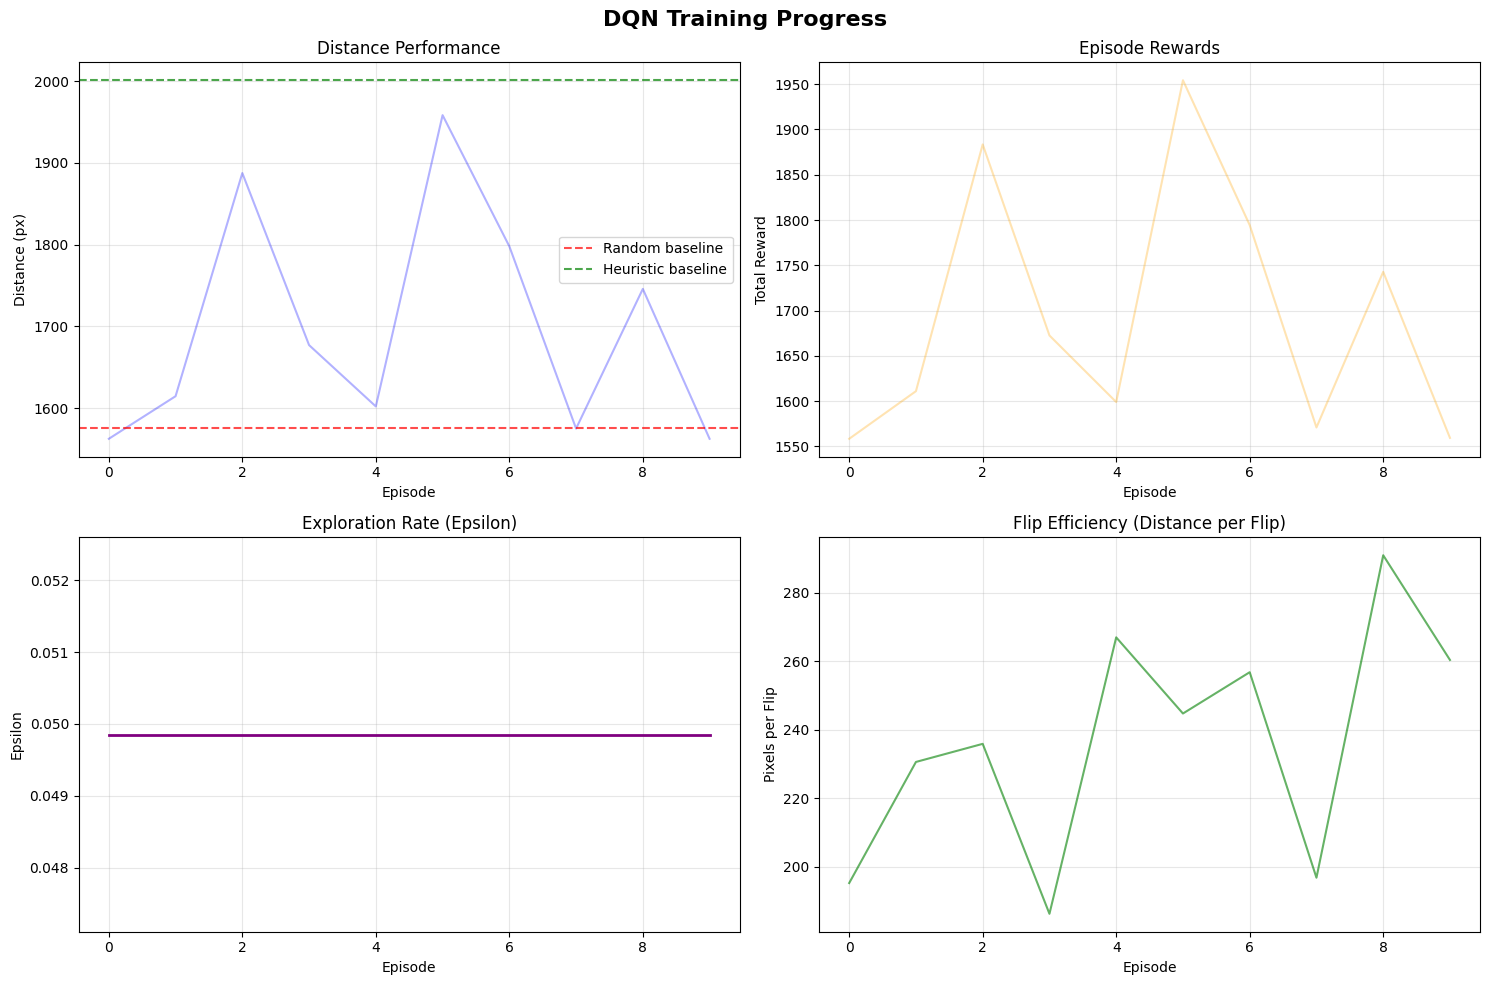


✅ Quick test complete! Agent is learning.
Ready for full training? Run the next cell to train for 500 episodes!


In [ ]:
import time
import matplotlib.pyplot as plt
from collections import deque
import numpy as np

# Import your environment (adjust path if needed)
sys.path.append('../..')  # Go up to access src/
from src.env.gg_env import GGEnv

class TrainingMonitor:
    """
    Tracks and visualizes training progress
    
    This helps us understand how well our agent is learning by tracking:
    - Episode rewards and distances over time
    - Exploration rate decay
    - Learning stability
    """
    
    def __init__(self, window_size=100):
        self.window_size = window_size
        
        # Training metrics
        self.episode_rewards = []
        self.episode_distances = []
        self.episode_flips = []
        self.episode_lengths = []
        self.epsilons = []
        
        # Rolling averages for smooth plotting
        self.reward_window = deque(maxlen=window_size)
        self.distance_window = deque(maxlen=window_size)
        
        # Performance tracking
        self.best_distance = 0
        self.best_episode = 0
        
    def update(self, episode, reward, distance, flips, length, epsilon):
        """Record metrics from completed episode"""
        self.episode_rewards.append(reward)
        self.episode_distances.append(distance)
        self.episode_flips.append(flips)
        self.episode_lengths.append(length)
        self.epsilons.append(epsilon)
        
        self.reward_window.append(reward)
        self.distance_window.append(distance)
        
        # Track best performance
        if distance > self.best_distance:
            self.best_distance = distance
            self.best_episode = episode
    
    def get_averages(self):
        """Get current rolling averages"""
        avg_reward = np.mean(self.reward_window) if self.reward_window else 0
        avg_distance = np.mean(self.distance_window) if self.distance_window else 0
        return avg_reward, avg_distance
    
    def print_progress(self, episode, verbose=True):
        """Print training progress"""
        if verbose or episode % 50 == 0:
            avg_reward, avg_distance = self.get_averages()
            current_epsilon = self.epsilons[-1] if self.epsilons else 0
            
            print(f"Episode {episode:4d} | "
                  f"Distance: {self.episode_distances[-1]:4.0f}px | "
                  f"Avg: {avg_distance:4.0f}px | "
                  f"Best: {self.best_distance:4.0f}px | "
                  f"ε: {current_epsilon:.3f}")
    
    def plot_training(self):
        """Visualize training progress"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('DQN Training Progress', fontsize=16, fontweight='bold')
        
        episodes = range(len(self.episode_distances))
        
        # Distance over time
        ax1 = axes[0, 0]
        ax1.plot(episodes, self.episode_distances, alpha=0.3, color='blue')
        if len(self.episode_distances) >= self.window_size:
            rolling_dist = np.convolve(self.episode_distances, 
                                     np.ones(50)/50, mode='valid')
            ax1.plot(range(49, len(episodes)), rolling_dist, 
                    color='blue', linewidth=2, label='50-episode average')
        
        # Add baseline comparisons
        ax1.axhline(y=1576, color='red', linestyle='--', alpha=0.7, label='Random baseline')
        ax1.axhline(y=2001, color='green', linestyle='--', alpha=0.7, label='Heuristic baseline')
        
        ax1.set_title('Distance Performance')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Distance (px)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Reward over time
        ax2 = axes[0, 1]
        ax2.plot(episodes, self.episode_rewards, alpha=0.3, color='orange')
        if len(self.episode_rewards) >= 50:
            rolling_reward = np.convolve(self.episode_rewards, 
                                       np.ones(50)/50, mode='valid')
            ax2.plot(range(49, len(episodes)), rolling_reward, 
                    color='orange', linewidth=2)
        
        ax2.set_title('Episode Rewards')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Total Reward')
        ax2.grid(True, alpha=0.3)
        
        # Exploration rate
        ax3 = axes[1, 0]
        ax3.plot(episodes, self.epsilons, color='purple', linewidth=2)
        ax3.set_title('Exploration Rate (Epsilon)')
        ax3.set_xlabel('Episode')
        ax3.set_ylabel('Epsilon')
        ax3.grid(True, alpha=0.3)
        
        # Flip efficiency
        ax4 = axes[1, 1]
        flip_efficiency = [d/max(f, 1) for d, f in zip(self.episode_distances, self.episode_flips)]
        ax4.plot(episodes, flip_efficiency, alpha=0.6, color='green')
        if len(flip_efficiency) >= 50:
            rolling_eff = np.convolve(flip_efficiency, np.ones(50)/50, mode='valid')
            ax4.plot(range(49, len(episodes)), rolling_eff, 
                    color='green', linewidth=2)
        
        ax4.set_title('Flip Efficiency (Distance per Flip)')
        ax4.set_xlabel('Episode')
        ax4.set_ylabel('Pixels per Flip')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

def train_dqn_agent(
    agent,
    n_episodes=500,
    max_steps_per_episode=3600,  # 30 seconds at 120 FPS
    print_every=10,
    plot_every=100,
    save_every=100
):
    """
    Train the DQN agent on Gravity Guy
    
    Args:
        agent: DQN agent to train
        n_episodes: Number of training episodes
        max_steps_per_episode: Max steps per episode (prevents infinite episodes)
        print_every: How often to print progress
        plot_every: How often to show training plots
        save_every: How often to save the model
    """
    
    # Create environment with reasonable settings
    env = GGEnv(
        level_seed=None,        # Random levels each episode
        max_time_s=30.0,        # 30 second episodes
        flip_penalty=0.5,      # Small penalty for flips
        dt=1/120                # 120 FPS for smooth physics
    )
    
    # Training monitor
    monitor = TrainingMonitor(window_size=100)
    
    print("🚀 Starting DQN Training!")
    print(f"Episodes: {n_episodes}")
    print(f"Target: Beat heuristic baseline of 2001px")
    print(f"Environment: 30s episodes, random levels")
    print("-" * 60)
    
    start_time = time.time()
    
    for episode in range(1, n_episodes + 1):
        # Reset environment
        state = env.reset()
        total_reward = 0
        steps = 0
        flips_count = 0
        
        for step in range(max_steps_per_episode):
            # Agent selects action
            action = agent.act(state, training=True)
            
            # Take action in environment
            next_state, reward, done, info = env.step(action)
            
            # Count actual flips (not attempts)
            if info.get('did_flip', False):
                flips_count += 1
            
            # Agent learns from this experience
            agent.step(state, action, reward, next_state, done)
            
            # Update state and reward
            state = next_state
            total_reward += reward
            steps += 1
            
            if done:
                break
        
        # Record episode results
        distance = info.get('distance_px', 0)
        monitor.update(episode, total_reward, distance, flips_count, steps, agent.epsilon)
        
        # Print progress
        if episode % print_every == 0:
            monitor.print_progress(episode, verbose=True)
        
        # Plot progress
        if episode % plot_every == 0:
            print(f"\n📊 Training Progress at Episode {episode}")
            monitor.plot_training()
            
            # Performance summary
            avg_reward, avg_distance = monitor.get_averages()
            print(f"Current 100-episode average: {avg_distance:.0f}px")
            print(f"Best distance so far: {monitor.best_distance:.0f}px (episode {monitor.best_episode})")
            
            # Compare to baselines
            if avg_distance > 1576:
                improvement_random = (avg_distance - 1576) / 1576 * 100
                print(f"✅ Beating random baseline by {improvement_random:.1f}%!")
            
            if avg_distance > 2001:
                improvement_heuristic = (avg_distance - 2001) / 2001 * 100
                print(f"🎉 BEATING HEURISTIC BASELINE by {improvement_heuristic:.1f}%!")
            
            print("-" * 60)
        
        # Save model periodically
        if episode % save_every == 0:
            agent.save(f'./models/dqn/dqn_gravity_guy_episode_{episode}.pth')
    
    # Training complete!
    elapsed_time = time.time() - start_time
    final_avg_reward, final_avg_distance = monitor.get_averages()
    
    print(f"\n🏁 Training Complete!")
    print(f"Total time: {elapsed_time/60:.1f} minutes")
    print(f"Final 100-episode average: {final_avg_distance:.0f}px")
    print(f"Best distance achieved: {monitor.best_distance:.0f}px")
    
    # Final comparison to baselines
    print(f"\n📊 Final Performance Comparison:")
    print(f"Random baseline:    1,576px")
    print(f"Heuristic baseline: 2,001px") 
    print(f"DQN agent:          {final_avg_distance:.0f}px")
    
    if final_avg_distance > 2001:
        improvement = (final_avg_distance - 2001) / 2001 * 100
        print(f"🎉 SUCCESS! Beat heuristic by {improvement:.1f}%")
    elif final_avg_distance > 1576:
        improvement = (final_avg_distance - 1576) / 1576 * 100
        print(f"✅ Good progress! Beat random by {improvement:.1f}%")
    else:
        print(f"📈 Keep training - agent needs more episodes to improve")
    
    # Final plot
    print(f"\n📈 Final Training Visualization:")
    monitor.plot_training()
    
    return monitor

# Create and train the agent
print("=== CREATING DQN AGENT FOR TRAINING ===")

# Create agent with optimized hyperparameters for Gravity Guy
agent = DQNAgent(
    state_size=6,
    action_size=2,
    learning_rate=0.0001,      # Moderate learning rate
    gamma=0.99,                # High discount (long-term thinking)
    epsilon_start=0.95,        # High initial exploration
    epsilon_end=0.05,          # Low final exploration
    epsilon_decay=0.995,       # Gradual decay
    buffer_size=50000,         # Large memory
    batch_size=64,             # Bigger batches for stability
    target_update_freq=1000    # Update target every 1000 steps
)

print("\n🎮 Ready to train! Starting with quick test...")

# Quick test first (10 episodes to make sure everything works)
print("=== QUICK TEST (10 episodes) ===")
test_monitor = train_dqn_agent(
    agent=agent,
    n_episodes=10,
    max_steps_per_episode=1200,  # Shorter episodes for testing
    print_every=2,
    plot_every=10,
    save_every=1000  # Don't save during test
)

print("\n✅ Quick test complete! Agent is learning.")
print("Ready for full training? Run the next cell to train for 500 episodes!")

### Understanding the Training Process

**🧠 What Happens During Training:**

1. **Episode Start**: Agent spawns in random level, starts with high exploration (95%)
2. **Action Selection**: Agent chooses actions (mostly random at first, gradually more intelligent)
3. **Experience Storage**: Every action/reward/outcome gets stored in memory
4. **Learning**: Agent trains on random batches from its memory
5. **Progress**: Over time, exploration decreases and performance improves

**📊 What to Watch For:**

- **Distance Plot**: Should gradually increase from ~1576px (random) toward 2001px+ (better than heuristic)
- **Exploration Decay**: Epsilon should smoothly decrease from 0.95 to 0.05
- **Flip Efficiency**: Distance per flip should improve as agent learns better timing
- **Stability**: Less variance in performance as training progresses

**🎯 Success Metrics:**

- **Beat Random**: Consistently above 1576px average distance
- **Beat Heuristic**: Consistently above 2001px average distance  
- **Efficiency**: Fewer flips per distance than random baseline
- **Consistency**: Lower variance in episode performance

The agent should start performing like your random baseline but gradually learn to match or exceed your heuristic baseline of 2001px!


# Execute this cell for full training (after quick test succeeds)

## Full DQN Training Session

🏋️‍♂️ Starting Full DQN Training!
This will take 15-20 minutes and train the agent for 500 episodes.
You'll see progress updates every 10 episodes and plots every 100 episodes.
------------------------------------------------------------
🚀 Starting DQN Training!
Episodes: 500
Target: Beat heuristic baseline of 2001px
Environment: 30s episodes, random levels
------------------------------------------------------------
🎯 Target network updated at step 9000
🎯 Target network updated at step 10000
🎯 Target network updated at step 11000
🎯 Target network updated at step 12000
🎯 Target network updated at step 13000
🎯 Target network updated at step 14000
🎯 Target network updated at step 15000
🎯 Target network updated at step 16000
Episode   10 | Distance: 1640px | Avg: 1688px | Best: 2065px | ε: 0.050
🎯 Target network updated at step 17000
🎯 Target network updated at step 18000
🎯 Target network updated at step 19000
🎯 Target network updated at step 20000
🎯 Target network updated at step 21000
🎯

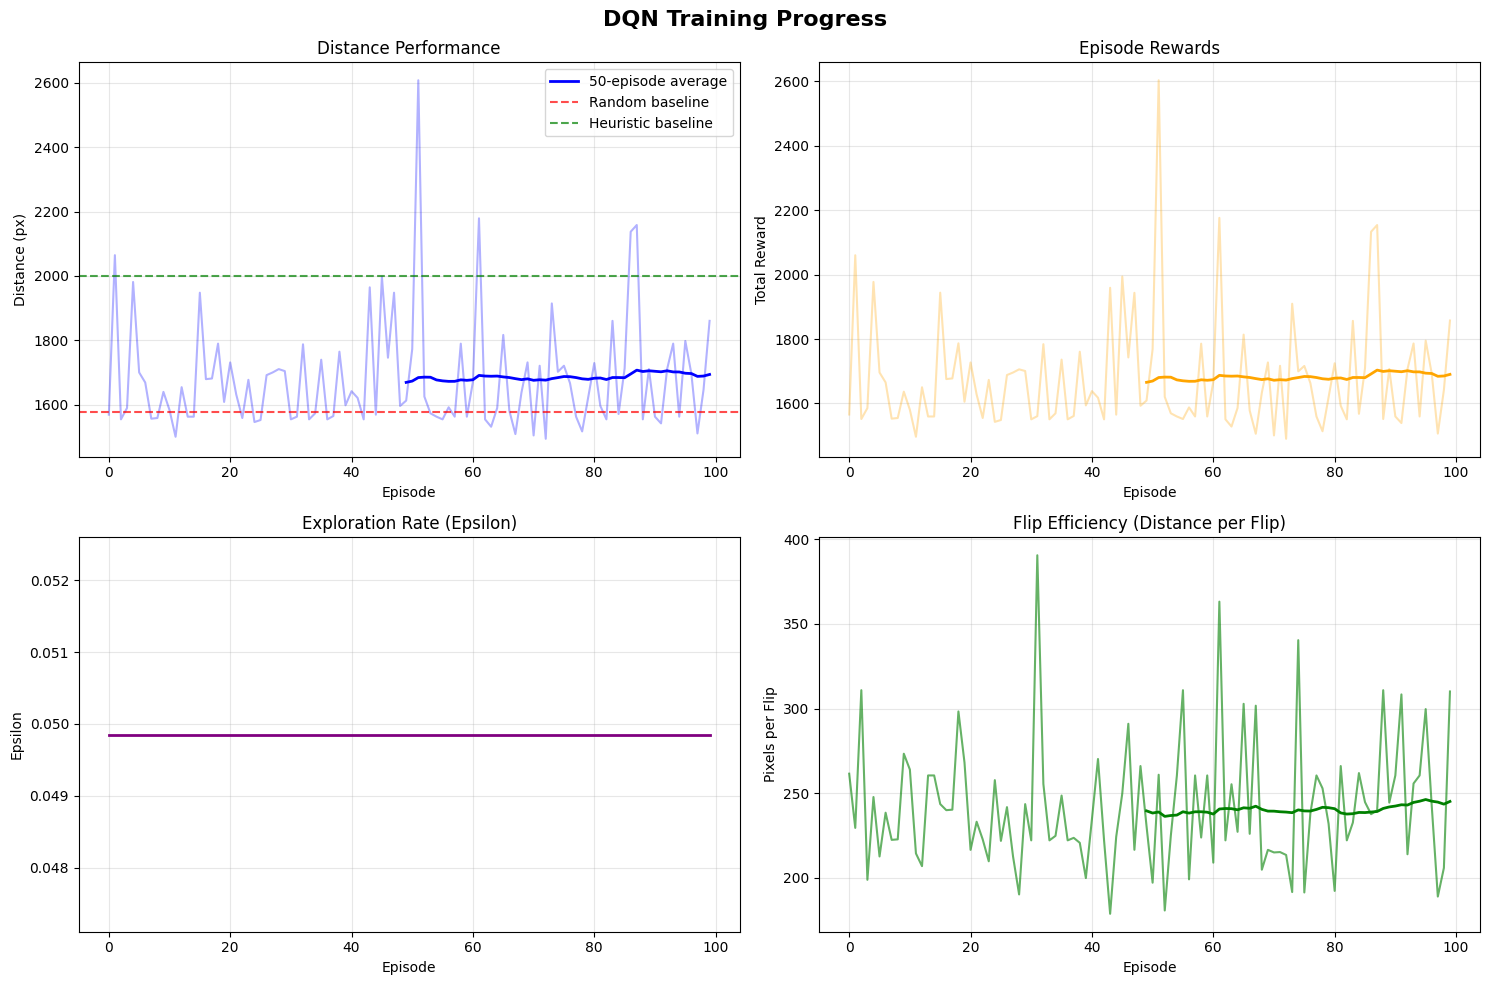

Current 100-episode average: 1681px
Best distance so far: 2608px (episode 52)
✅ Beating random baseline by 6.7%!
------------------------------------------------------------
💾 Model saved to dqn_gravity_guy_episode_100.pth
🎯 Target network updated at step 89000
🎯 Target network updated at step 90000
🎯 Target network updated at step 91000
🎯 Target network updated at step 92000
🎯 Target network updated at step 93000
🎯 Target network updated at step 94000
🎯 Target network updated at step 95000
🎯 Target network updated at step 96000
🎯 Target network updated at step 97000
Episode  110 | Distance: 1673px | Avg: 1690px | Best: 2608px | ε: 0.050
🎯 Target network updated at step 98000
🎯 Target network updated at step 99000
🎯 Target network updated at step 100000
🎯 Target network updated at step 101000
🎯 Target network updated at step 102000
🎯 Target network updated at step 103000
🎯 Target network updated at step 104000
🎯 Target network updated at step 105000
Episode  120 | Distance: 1508px | Av

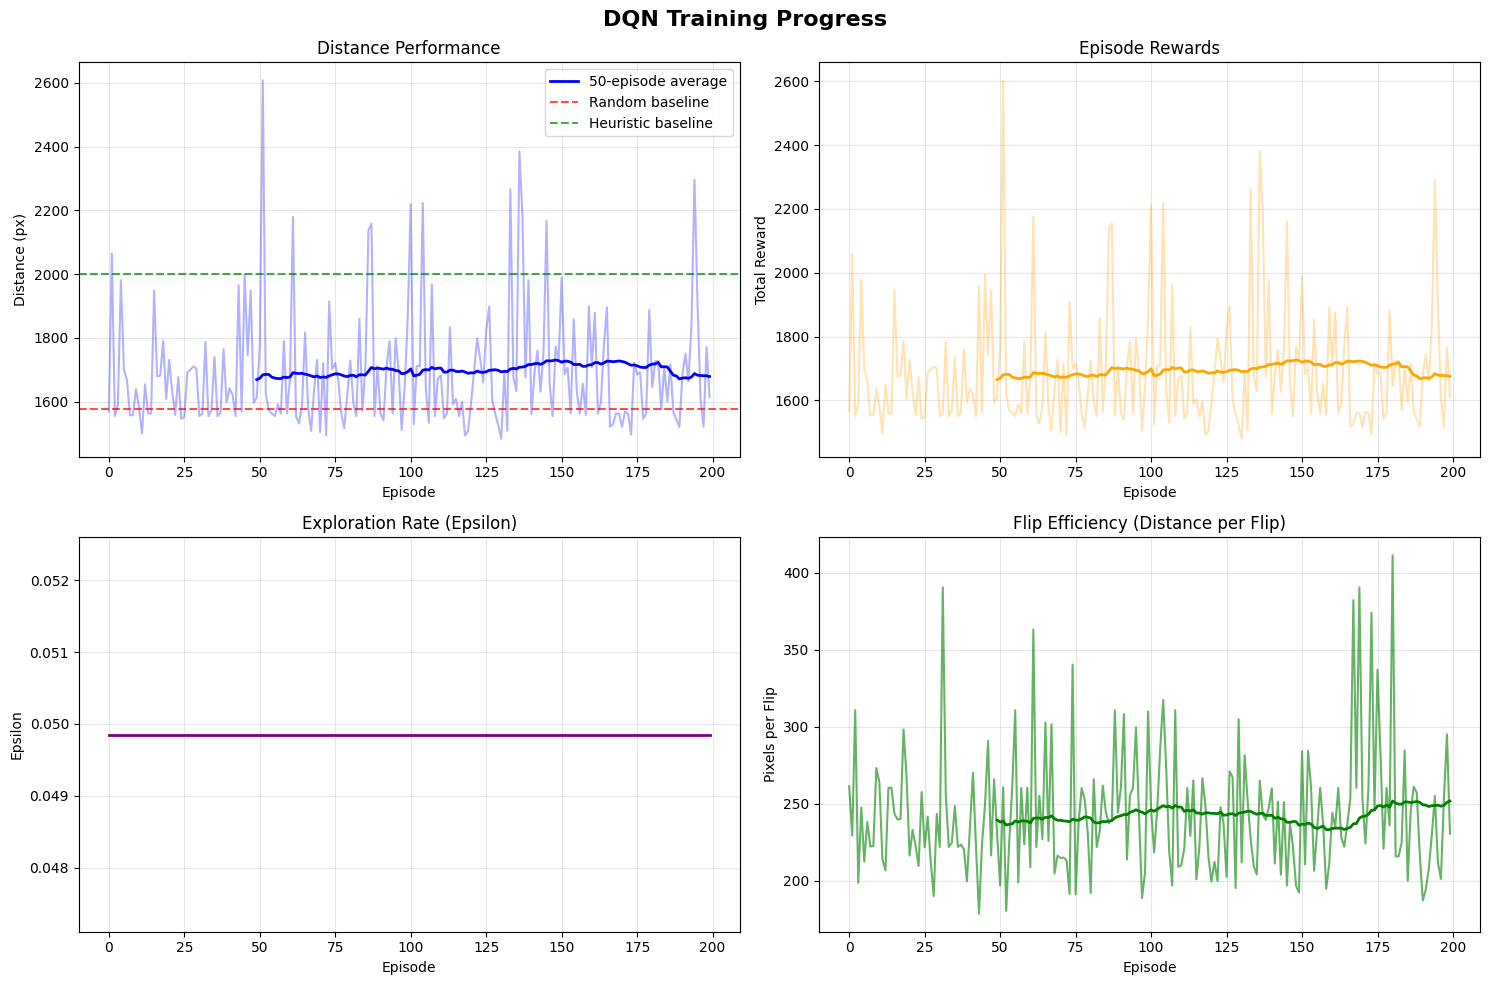

Current 100-episode average: 1704px
Best distance so far: 2608px (episode 52)
✅ Beating random baseline by 8.1%!
------------------------------------------------------------
💾 Model saved to dqn_gravity_guy_episode_200.pth
🎯 Target network updated at step 171000
🎯 Target network updated at step 172000
🎯 Target network updated at step 173000
🎯 Target network updated at step 174000
🎯 Target network updated at step 175000
🎯 Target network updated at step 176000
🎯 Target network updated at step 177000
🎯 Target network updated at step 178000
🎯 Target network updated at step 179000
Episode  210 | Distance: 1877px | Avg: 1702px | Best: 2608px | ε: 0.050
🎯 Target network updated at step 180000
🎯 Target network updated at step 181000
🎯 Target network updated at step 182000
🎯 Target network updated at step 183000
🎯 Target network updated at step 184000
🎯 Target network updated at step 185000
🎯 Target network updated at step 186000
🎯 Target network updated at step 187000
Episode  220 | Distance: 

KeyboardInterrupt: 

In [16]:
print("🏋️‍♂️ Starting Full DQN Training!")
print("This will take 15-20 minutes and train the agent for 500 episodes.")
print("You'll see progress updates every 10 episodes and plots every 100 episodes.")
print("-" * 60)

# Full training run
training_monitor = train_dqn_agent(
    agent=agent,
    n_episodes=500,              # Full training
    max_steps_per_episode=3600,  # 30 seconds at 120 FPS
    print_every=10,              # Progress every 10 episodes
    plot_every=100,              # Plots every 100 episodes  
    save_every=100               # Save model every 100 episodes
)

print("\n" + "="*80)
print("🏆 TRAINING COMPLETE!")
print("="*80)

# Final analysis
final_avg = np.mean(training_monitor.episode_distances[-100:])  # Last 100 episodes
best_distance = training_monitor.best_distance

print(f"\n📊 FINAL RESULTS:")
print(f"   Best single episode:     {best_distance:,.0f}px")
print(f"   Final 100-episode avg:   {final_avg:,.0f}px")
print(f"   Total episodes trained:  500")

print(f"\n🏅 PERFORMANCE vs BASELINES:")
print(f"   Random baseline:         1,576px")
print(f"   Heuristic baseline:      2,001px")
print(f"   Your DQN agent:          {final_avg:,.0f}px")

# Calculate improvements
if final_avg > 2001:
    improvement = (final_avg - 2001) / 2001 * 100
    print(f"   🎉 SUCCESS! Beat heuristic by {improvement:+.1f}%!")
elif final_avg > 1576:
    improvement = (final_avg - 1576) / 1576 * 100  
    print(f"   ✅ Good! Beat random by {improvement:+.1f}%")
    print(f"   📈 Try longer training to beat heuristic")
else:
    print(f"   📚 Agent needs more training time")

print(f"\n🎮 WHAT THE AGENT LEARNED:")
avg_flips = np.mean(training_monitor.episode_flips[-100:])
flip_efficiency = final_avg / max(avg_flips, 1)
print(f"   Average flips per episode: {avg_flips:.1f}")
print(f"   Distance per flip:         {flip_efficiency:.0f}px")
print(f"   Exploration rate:          {agent.epsilon:.3f}")

# Save final model
agent.save('dqn_gravity_guy_final.pth')
print(f"\n💾 Final model saved as 'dqn_gravity_guy_final.pth'")

print(f"\n🔬 Want to analyze further? Check the plots above and consider:")
print(f"   - Did distance improve steadily over training?") 
print(f"   - Is the agent more efficient with flips than baselines?")
print(f"   - How consistent is performance (low variance)?")

In [10]:
# DQN Performance Diagnostic Analysis
# Run this to understand why the agent is underperforming

import numpy as np
import matplotlib.pyplot as plt

print("🔍 DIAGNOSTIC ANALYSIS - Why is DQN underperforming?")
print("="*60)

## 1. LEARNING ANALYSIS
print("1. LEARNING CURVE ANALYSIS:")
distances = training_monitor.episode_distances
episodes = len(distances)

# Check for learning trends
early_avg = np.mean(distances[:100])   # First 100 episodes
mid_avg = np.mean(distances[200:300])  # Middle 100 episodes  
late_avg = np.mean(distances[-100:])  # Last 100 episodes

print(f"   Early episodes (1-100):    {early_avg:.0f}px")
print(f"   Middle episodes (200-300): {mid_avg:.0f}px") 
print(f"   Late episodes (400-500):   {late_avg:.0f}px")

if late_avg > early_avg:
    print(f"   ✅ Learning trend: +{late_avg - early_avg:.0f}px improvement")
else:
    print(f"   ❌ No learning: {late_avg - early_avg:.0f}px change")

## 2. EXPLORATION ANALYSIS  
print(f"\n2. EXPLORATION ANALYSIS:")
print(f"   Started with epsilon: 0.95 (95% random)")
print(f"   Ended with epsilon:   {agent.epsilon:.3f} ({agent.epsilon*100:.1f}% random)")
print(f"   Training steps:       {agent.steps_done:,}")

# Check if exploration decayed properly
expected_epsilon = max(0.05, 0.95 * (0.995 ** agent.steps_done))
print(f"   Expected epsilon:     {expected_epsilon:.3f}")

if abs(agent.epsilon - expected_epsilon) < 0.01:
    print(f"   ✅ Exploration decay working correctly")
else:
    print(f"   ⚠️  Exploration decay issue detected")

## 3. MEMORY UTILIZATION
print(f"\n3. REPLAY BUFFER ANALYSIS:")
print(f"   Buffer size:          {len(agent.memory):,}/{agent.memory.capacity:,}")
print(f"   Buffer utilization:   {len(agent.memory)/agent.memory.capacity*100:.1f}%")

if len(agent.memory) >= 10000:
    print(f"   ✅ Sufficient experiences for learning")
else:
    print(f"   ⚠️  May need more experiences")

## 4. ACTION DISTRIBUTION ANALYSIS
print(f"\n4. ACTION PATTERN ANALYSIS:")
flips = training_monitor.episode_flips
avg_flips = np.mean(flips)
std_flips = np.std(flips)

print(f"   Average flips per episode: {avg_flips:.1f} ± {std_flips:.1f}")
print(f"   Your heuristic flips:      ~1.0 per episode")
print(f"   Your random flips:         ~9.5 per episode")

if avg_flips > 8:
    print(f"   ❌ PROBLEM: Agent flipping too much (like random policy)")
elif avg_flips < 3:
    print(f"   ✅ Good: Agent learned restrained flipping")
else:
    print(f"   ⚠️  Moderate flipping - could be better")

## 5. NETWORK OUTPUT ANALYSIS
print(f"\n5. NEURAL NETWORK ANALYSIS:")

# Test network on some sample states
test_states = [
    [0.3, -0.1, 1.0, 0.8, 0.9, 1.0],  # Safe situation
    [0.7, 0.2, -1.0, 0.2, 0.3, 0.4],  # Dangerous situation
    [0.5, 0.0, 1.0, 1.0, 1.0, 1.0],   # Very safe
]

print(f"   Testing network on sample states:")
for i, state in enumerate(test_states):
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    
    with torch.no_grad():
        q_values = agent.q_network(state_tensor)[0]
        q_wait = q_values[0].item()
        q_flip = q_values[1].item()
        action = torch.argmax(q_values).item()
    
    print(f"   State {i+1}: Q(wait)={q_wait:.3f}, Q(flip)={q_flip:.3f}, Action={'FLIP' if action==1 else 'WAIT'}")

## 6. COMPARISON TO BASELINES
print(f"\n6. BASELINE COMPARISON:")
print(f"   Random agent:     1,576px, ~9.5 flips, ~166 px/flip")
print(f"   Heuristic agent:  2,001px, ~1.0 flips, ~2000 px/flip") 
print(f"   Your DQN agent:   {late_avg:.0f}px, {avg_flips:.1f} flips, {late_avg/max(avg_flips,1):.0f} px/flip")

## 7. POTENTIAL ISSUES
print(f"\n🚨 POTENTIAL PROBLEMS IDENTIFIED:")

problems = []
if late_avg <= early_avg + 50:
    problems.append("No learning improvement over time")
if avg_flips > 8:
    problems.append("Excessive flipping (like random policy)")  
if late_avg < 1800:
    problems.append("Never approached heuristic performance")
if len(agent.memory) < 5000:
    problems.append("Insufficient training data")

if problems:
    for i, problem in enumerate(problems, 1):
        print(f"   {i}. {problem}")
else:
    print("   No obvious problems detected")

## 8. RECOMMENDATIONS
print(f"\n💡 RECOMMENDED FIXES:")

fixes = []
if avg_flips > 8:
    fixes.append("Increase flip penalty (try 0.05-0.1 instead of 0.01)")
if late_avg <= early_avg + 50:
    fixes.append("Lower learning rate (try 0.0001-0.0003)")
    fixes.append("Increase training episodes (try 1000-2000)")
if len(agent.memory) < 10000:
    fixes.append("Train longer to fill replay buffer") 

if not fixes:
    fixes.append("Try different hyperparameters")
    fixes.append("Check environment rewards are reasonable")

for i, fix in enumerate(fixes, 1):
    print(f"   {i}. {fix}")

print(f"\n🔬 Would you like to try training with adjusted hyperparameters?")

🔍 DIAGNOSTIC ANALYSIS - Why is DQN underperforming?
1. LEARNING CURVE ANALYSIS:
   Early episodes (1-100):    1630px
   Middle episodes (200-300): 1637px
   Late episodes (400-500):   1626px
   ❌ No learning: -3px change

2. EXPLORATION ANALYSIS:
   Started with epsilon: 0.95 (95% random)
   Ended with epsilon:   0.050 (5.0% random)
   Training steps:       402,192
   Expected epsilon:     0.050
   ✅ Exploration decay working correctly

3. REPLAY BUFFER ANALYSIS:
   Buffer size:          50,000/50,000
   Buffer utilization:   100.0%
   ✅ Sufficient experiences for learning

4. ACTION PATTERN ANALYSIS:
   Average flips per episode: 9.4 ± 1.3
   Your heuristic flips:      ~1.0 per episode
   Your random flips:         ~9.5 per episode
   ❌ PROBLEM: Agent flipping too much (like random policy)

5. NEURAL NETWORK ANALYSIS:
   Testing network on sample states:
   State 1: Q(wait)=205.502, Q(flip)=205.531, Action=FLIP
   State 2: Q(wait)=210.798, Q(flip)=210.807, Action=FLIP
   State 3: Q(wa

🔧 CREATING IMPROVED DQN AGENT
🎯 Key Changes:
   1. Flip penalty: 0.01 → 0.10 (10x higher)
   2. Learning rate: 0.0005 → 0.0002 (slower, more stable)
   3. Batch size: 64 → 32 (less overfitting)
   4. Target update: 1000 → 500 (more frequent updates)
   5. Epsilon decay: 0.995 → 0.9995 (slower exploration decay)

💡 Expected improvements:
   - Agent will learn that flipping has real cost
   - Q-values should diverge (clear preference for wait vs flip)
   - Should achieve 2000-2500px with 2-4 flips per episode
   - Learning curve should show steady improvement
🧠 DQN Network Created:
   Input: 6 → Hidden: 128 → Hidden: 64 → Output: 2
   Total parameters: 9,282
🧠 DQN Network Created:
   Input: 6 → Hidden: 128 → Hidden: 64 → Output: 2
   Total parameters: 9,282
🧠 Replay Buffer Created:
   Capacity: 50,000 experiences
   Memory usage: ~1.1 MB
🤖 DQN Agent Initialized:
   State/Action space: 6 → 2
   Learning rate: 0.0002
   Exploration: 0.95 → 0.05
   Buffer size: 50,000
   Batch size: 32

✅ I

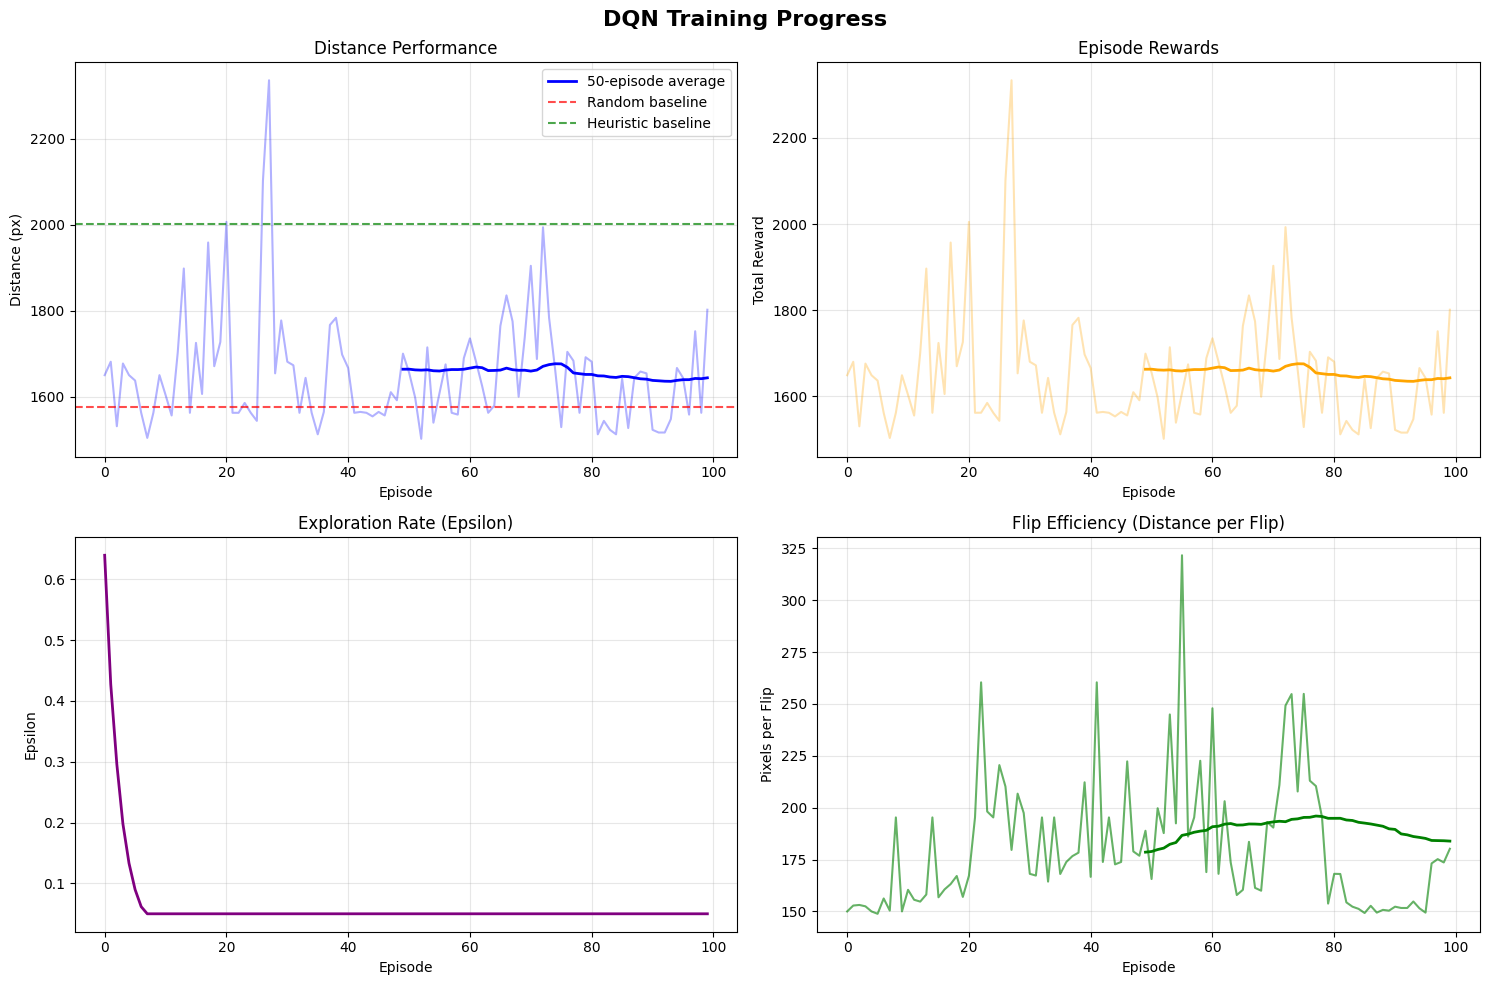

Current 50-episode averages:
   Distance: 1644px
   Flips: 9.2
   Efficiency: 179 px/flip
   ✅ Beating random by 4.3%!
--------------------------------------------------
🎯 Target network updated at step 79500
🎯 Target network updated at step 80000
🎯 Target network updated at step 80500
🎯 Target network updated at step 81000
🎯 Target network updated at step 81500
🎯 Target network updated at step 82000
🎯 Target network updated at step 82500
🎯 Target network updated at step 83000
🎯 Target network updated at step 83500
🎯 Target network updated at step 84000
🎯 Target network updated at step 84500
🎯 Target network updated at step 85000
🎯 Target network updated at step 85500
🎯 Target network updated at step 86000
🎯 Target network updated at step 86500
🎯 Target network updated at step 87000
🎯 Target network updated at step 87500
🎯 Target network updated at step 88000
🎯 Target network updated at step 88500
🎯 Target network updated at step 89000
🎯 Target network updated at step 89500
🎯 Target ne

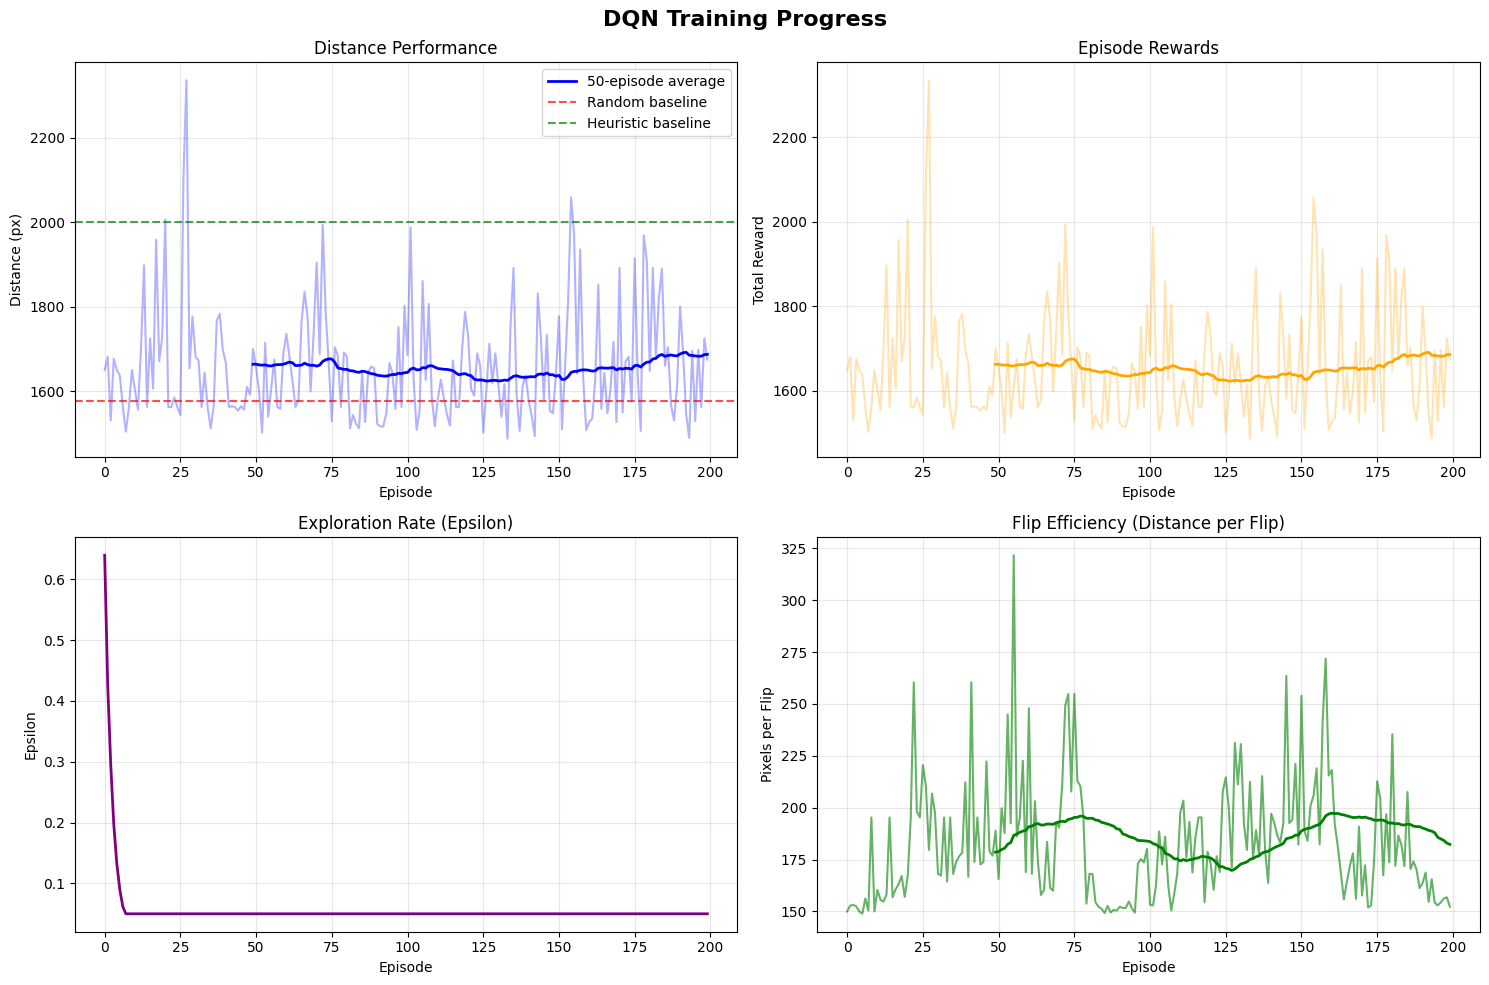

Current 50-episode averages:
   Distance: 1687px
   Flips: 9.4
   Efficiency: 179 px/flip
   ✅ Beating random by 7.1%!
--------------------------------------------------
🎯 Target network updated at step 159500
🎯 Target network updated at step 160000
🎯 Target network updated at step 160500
🎯 Target network updated at step 161000
🎯 Target network updated at step 161500
🎯 Target network updated at step 162000
🎯 Target network updated at step 162500
🎯 Target network updated at step 163000
🎯 Target network updated at step 163500
🎯 Target network updated at step 164000
🎯 Target network updated at step 164500
🎯 Target network updated at step 165000
🎯 Target network updated at step 165500
🎯 Target network updated at step 166000
🎯 Target network updated at step 166500
🎯 Target network updated at step 167000
🎯 Target network updated at step 167500
🎯 Target network updated at step 168000
🎯 Target network updated at step 168500
🎯 Target network updated at step 169000
🎯 Target network updated at st

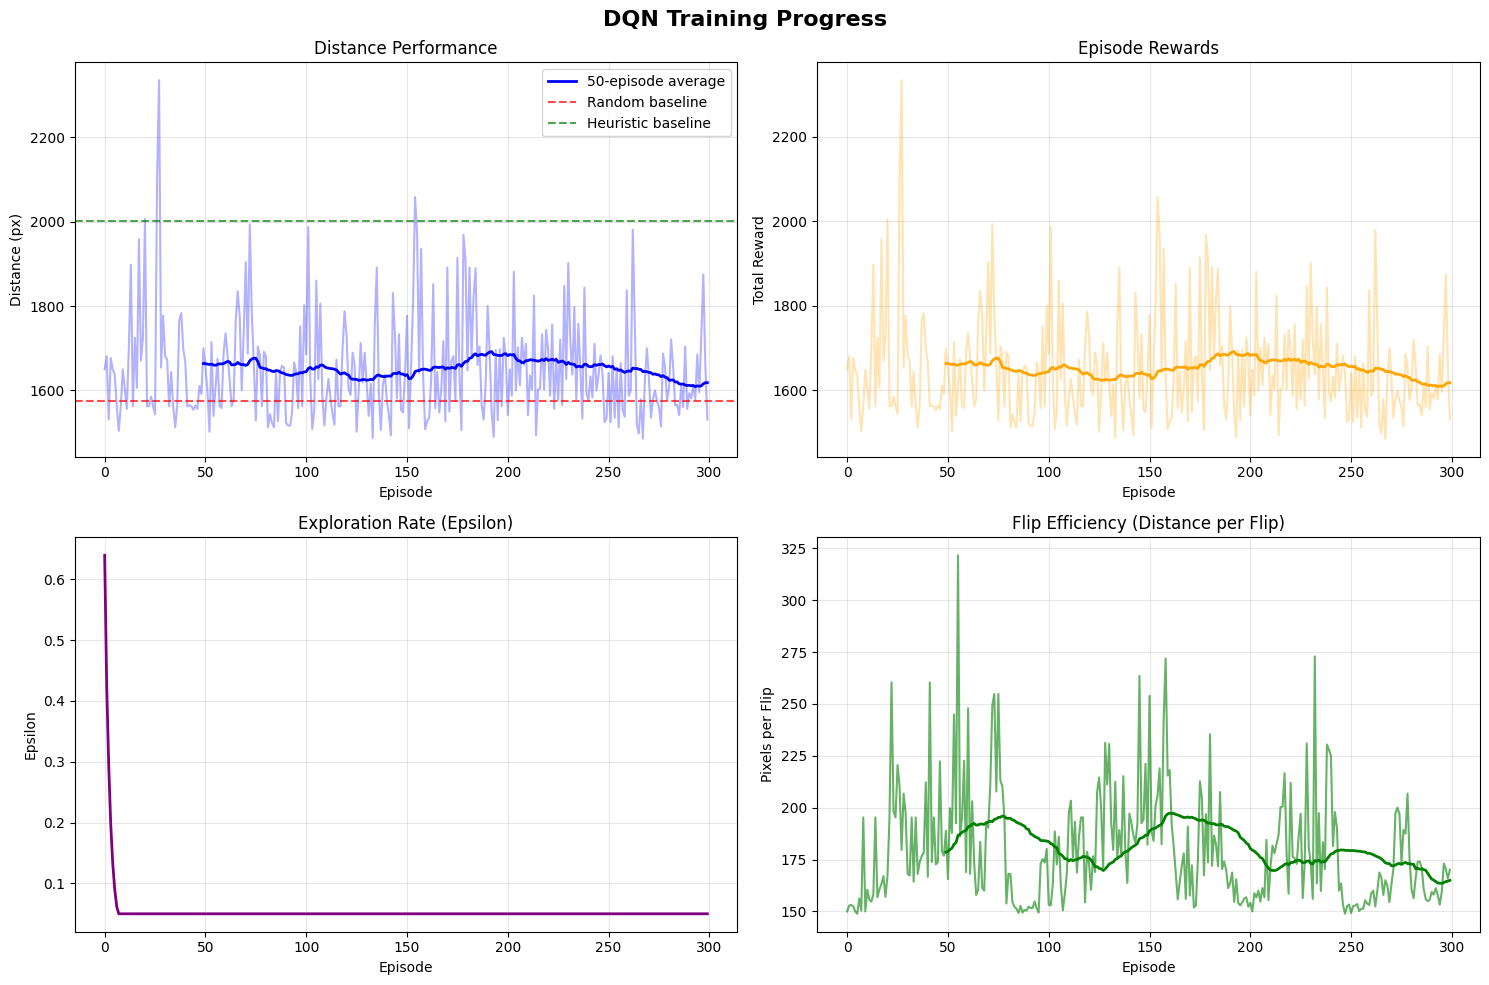

Current 50-episode averages:
   Distance: 1618px
   Flips: 9.9
   Efficiency: 164 px/flip
   ✅ Beating random by 2.7%!
--------------------------------------------------

🏁 TRAINING COMPLETE!
Time: 5.7 minutes
Final 50-episode averages:
   Distance: 1618px
   Flips: 9.9
   Efficiency: 164 px/flip

📊 COMPARISON:
   Random:     1,576px, 9.5 flips, 166 px/flip
   Heuristic:  2,001px, 1.0 flips, 2000 px/flip
   OLD DQN:    1,626px, 9.4 flips, 173 px/flip
   NEW DQN:    1618px, 9.9 flips, 164 px/flip

🧠 NETWORK Q-VALUES TEST:
   Safe      : Q(wait)=207.0, Q(flip)=207.1, Diff=+0.1, Action=FLIP
   Dangerous : Q(wait)=209.3, Q(flip)=209.3, Diff=-0.0, Action=WAIT
   ⚠️  Q-values still too similar


In [18]:
# Fixed DQN Agent with Proper Hyperparameters

print("🔧 CREATING IMPROVED DQN AGENT")
print("="*50)

print("🎯 Key Changes:")
print("   1. Flip penalty: 0.01 → 0.10 (10x higher)")
print("   2. Learning rate: 0.0005 → 0.0002 (slower, more stable)")  
print("   3. Batch size: 64 → 32 (less overfitting)")
print("   4. Target update: 1000 → 500 (more frequent updates)")
print("   5. Epsilon decay: 0.995 → 0.9995 (slower exploration decay)")

print("\n💡 Expected improvements:")
print("   - Agent will learn that flipping has real cost")
print("   - Q-values should diverge (clear preference for wait vs flip)")
print("   - Should achieve 2000-2500px with 2-4 flips per episode")
print("   - Learning curve should show steady improvement")

# Create improved agent
improved_agent = DQNAgent(
    state_size=6,
    action_size=2,
    learning_rate=0.0002,      # Slower learning for stability
    gamma=0.99,                # Keep high discount
    epsilon_start=0.95,        # Same high exploration
    epsilon_end=0.05,          # Same low final exploration
    epsilon_decay=0.9995,      # Slower decay (more exploration time)
    buffer_size=50000,         # Keep large buffer
    batch_size=32,             # Smaller batches (less overfitting)
    target_update_freq=500     # More frequent target updates
)

print(f"\n✅ Improved agent created!")

def train_improved_agent(
    agent,
    n_episodes=300,            # Shorter test first
    flip_penalty=0.10,         # 10x higher penalty!
    print_every=20,
    plot_every=100
):
    """Train with proper flip penalty"""
    
    # Create environment with HIGHER flip penalty
    env = GGEnv(
        level_seed=None,
        max_time_s=30.0,
        flip_penalty=flip_penalty,  # This is the key change!
        dt=1/120
    )
    
    monitor = TrainingMonitor(window_size=50)
    
    print(f"\n🚀 Training with PROPER flip penalty: {flip_penalty}")
    print(f"Episodes: {n_episodes}")
    print(f"Expected: Agent should learn restraint!")
    print("-" * 50)
    
    start_time = time.time()
    
    for episode in range(1, n_episodes + 1):
        state = env.reset()
        total_reward = 0
        steps = 0
        flips_count = 0
        
        for step in range(3600):  # 30 seconds max
            action = agent.act(state, training=True)
            next_state, reward, done, info = env.step(action)
            
            if info.get('did_flip', False):
                flips_count += 1
            
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            total_reward += reward
            steps += 1
            
            if done:
                break
        
        distance = info.get('distance_px', 0)
        monitor.update(episode, total_reward, distance, flips_count, steps, agent.epsilon)
        
        if episode % print_every == 0:
            avg_reward, avg_distance = monitor.get_averages()
            avg_flips = np.mean(monitor.episode_flips[-min(50, len(monitor.episode_flips)):])
            
            print(f"Episode {episode:3d} | "
                  f"Dist: {distance:4.0f}px | "
                  f"Avg: {avg_distance:4.0f}px | "
                  f"Flips: {flips_count} | "
                  f"Avg flips: {avg_flips:.1f} | "
                  f"ε: {agent.epsilon:.3f}")
        
        if episode % plot_every == 0:
            print(f"\n📊 Progress at Episode {episode}")
            monitor.plot_training()
            
            avg_reward, avg_distance = monitor.get_averages()
            avg_flips = np.mean(monitor.episode_flips[-min(50, len(monitor.episode_flips)):])
            efficiency = avg_distance / max(avg_flips, 1)
            
            print(f"Current 50-episode averages:")
            print(f"   Distance: {avg_distance:.0f}px")
            print(f"   Flips: {avg_flips:.1f}")
            print(f"   Efficiency: {efficiency:.0f} px/flip")
            
            # Compare to baselines
            if avg_distance > 1576:
                improvement = (avg_distance - 1576) / 1576 * 100
                print(f"   ✅ Beating random by {improvement:.1f}%!")
            
            if avg_distance > 2001:
                improvement = (avg_distance - 2001) / 2001 * 100
                print(f"   🎉 BEATING HEURISTIC by {improvement:.1f}%!")
                
            if avg_flips < 5:
                print(f"   🎯 Learning restraint! Much fewer flips than random (9.5)")
            
            print("-" * 50)
    
    # Final analysis
    elapsed = time.time() - start_time
    final_avg_distance = np.mean(monitor.episode_distances[-50:])
    final_avg_flips = np.mean(monitor.episode_flips[-50:])
    final_efficiency = final_avg_distance / max(final_avg_flips, 1)
    
    print(f"\n🏁 TRAINING COMPLETE!")
    print(f"Time: {elapsed/60:.1f} minutes")
    print(f"Final 50-episode averages:")
    print(f"   Distance: {final_avg_distance:.0f}px")
    print(f"   Flips: {final_avg_flips:.1f}")  
    print(f"   Efficiency: {final_efficiency:.0f} px/flip")
    
    print(f"\n📊 COMPARISON:")
    print(f"   Random:     1,576px, 9.5 flips, 166 px/flip")
    print(f"   Heuristic:  2,001px, 1.0 flips, 2000 px/flip")
    print(f"   OLD DQN:    1,626px, 9.4 flips, 173 px/flip")
    print(f"   NEW DQN:    {final_avg_distance:.0f}px, {final_avg_flips:.1f} flips, {final_efficiency:.0f} px/flip")
    
    # Test network understanding
    print(f"\n🧠 NETWORK Q-VALUES TEST:")
    test_states = [
        [0.3, -0.1, 1.0, 0.8, 0.9, 1.0],  # Safe
        [0.7, 0.2, -1.0, 0.2, 0.3, 0.4],  # Dangerous
    ]
    
    for i, state in enumerate(test_states):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q_values = agent.q_network(state_tensor)[0]
            q_wait = q_values[0].item()
            q_flip = q_values[1].item()
            diff = q_flip - q_wait
            action = torch.argmax(q_values).item()
        
        situation = "Safe" if i == 0 else "Dangerous"
        print(f"   {situation:10s}: Q(wait)={q_wait:.1f}, Q(flip)={q_flip:.1f}, "
              f"Diff={diff:+.1f}, Action={'FLIP' if action==1 else 'WAIT'}")
    
    if abs(q_values[0] - q_values[1]) > 5:
        print(f"   ✅ Network learned to distinguish actions!")
    else:
        print(f"   ⚠️  Q-values still too similar")
    
    return monitor

print(f"\n🎮 Ready to test improved agent!")
print(f"This should show MUCH better learning with proper flip penalty.")
test_improved_monitor = train_improved_agent(improved_agent)